# NLP Disaster Tweets Mini-Project

This project is about building an artificial intelligence algorithm to predict which tweets are about a real disaster and which are not. We have access to a dataset of 10,000 tweets tagged with 1 for disaster and 0 for not disasters. We are going to use natural language processing techniques and recurrent neuronal networks. 

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [31]:
train_csv = 'data/train.csv'

train_df = pd.read_csv(train_csv)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- **id:** a unique identifier for each tweet.
- **keyword:** a particular keyword from the tweet.
- **location:** the location the tweet.
- **text:** the text of the tweet.
- **target:** this denotes whether a tweet is about a real disaster (1) or not (0).


### Exploratory Data Analysis (EDA) 

In [6]:
train_df.shape

(7613, 5)

The traing set has 7613 records.

In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

There are some records with null values in the properties keyword and location. However for this analisis we are going to use the columns id, text and target.

In [32]:
train_df = train_df.drop(columns=['id', 'keyword', 'location'])

train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

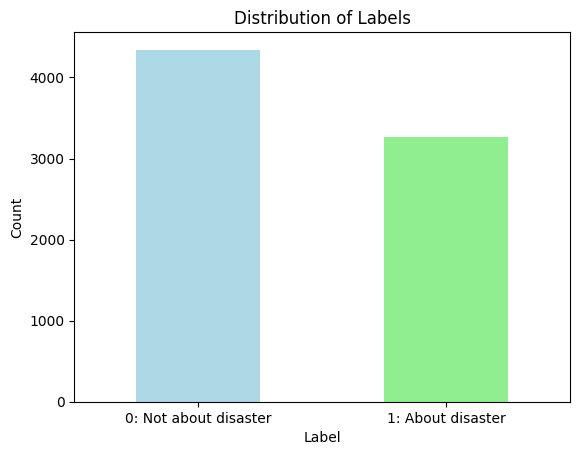

In [34]:
ax = train_df['target'].value_counts().plot(kind='bar', color=['lightblue', 'lightgreen'])

plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['0: Not about disaster', '1: About disaster'], rotation=0)
plt.show()

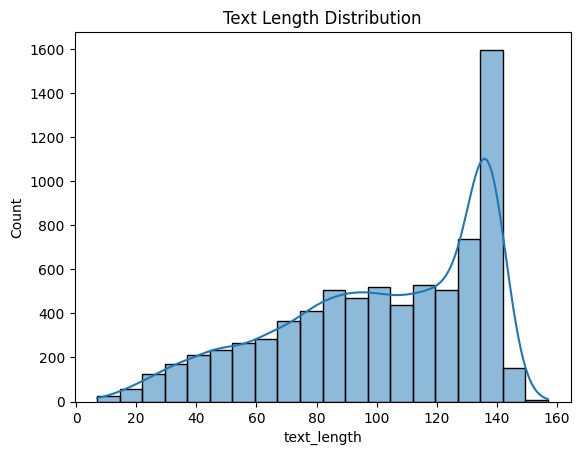

In [24]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x)))

sns.histplot(train_df['text_length'], bins=20, kde=True)
plt.title('Text Length Distribution')
plt.show()


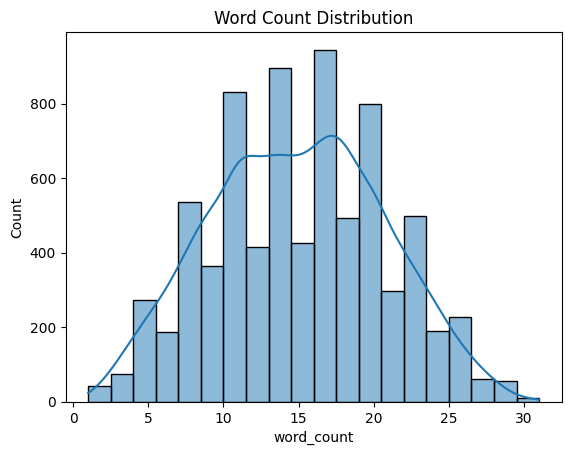

In [26]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

sns.histplot(train_df['word_count'], bins=20, kde=True)
plt.title('Word Count Distribution')
plt.show()



Removing stop words

In [41]:
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgevergara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorgevergara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
def remove_stop_words(sentence):
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words) 

In [47]:
train_df["text_cleaned"] = train_df["text"].apply(remove_stop_words)

In [ ]:
def plot_word_cloud(data):
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color='white',stopwords=stop_words)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

Word cloud Not about disaster

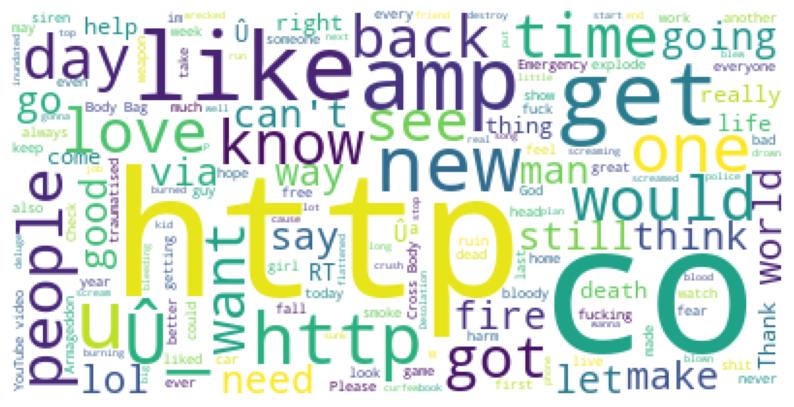

In [59]:
plot_word_cloud(train_df[train_df["target"]==0]["text"])

Word cloud About disaster

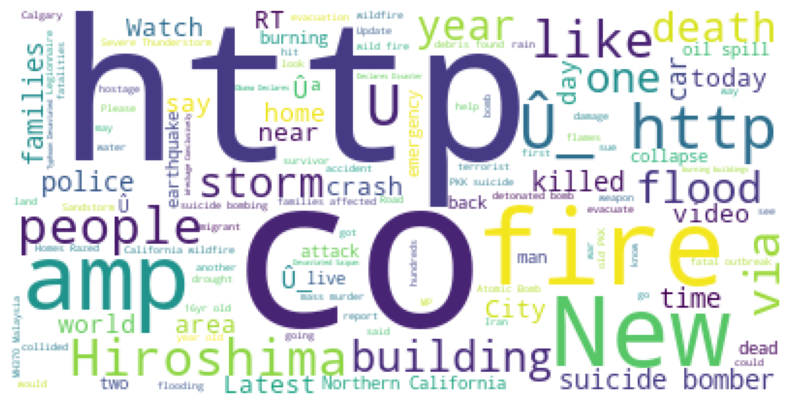

In [60]:
plot_word_cloud(train_df[train_df["target"]==1]["text"])

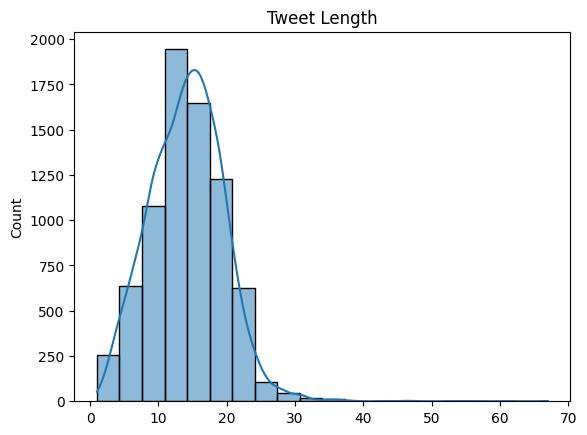

Tweet Length mean: 14.18429003021148


In [78]:
tweet_lengths = [len(seq.split(' ')) for seq in train_df['text_cleaned']]
sns.histplot(tweet_lengths, bins=20, kde=True)
plt.title("Tweet Length")
plt.show()

print(f"Tweet Length mean: {np.mean(tweet_lengths)}")

### Model Architecture

In [118]:
def plot_acc_and_loss(metrics):
    acc = metrics.history['acc']
    val_acc = metrics.history['val_acc']
    loss = metrics.history['loss']
    val_loss = metrics.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training ACC')
    plt.plot(epochs_range, val_acc, label='Validation ACC')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation ACC')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()

Split the dataset in 80% as train data and 20% as validation data

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text_cleaned"], 
    train_df["target"], 
    test_size=0.2, 
    random_state=42)

We are going to tokenize the tweets. Tokenizer is the transformation of words into numbers. Then, we are going to pad all the tweets with 20 words each.

In [104]:
max_words = 15000
max_len = 20

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

We are going to define a recurrent neuronal network in order to classify the tweets.

- Embedding layer: transforms the tokenizer word into a meaningful numeric representation.
- LSTM (Long Short-Term Memory): Process the text sequentially.
- Dense Layer: generate the output.

In [123]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [126]:
history = model.fit(
    X_train_pad, 
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test)
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9897 - loss: 0.0291 - val_acc: 0.7426 - val_loss: 1.1576
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9907 - loss: 0.0240 - val_acc: 0.7577 - val_loss: 1.1715
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9906 - loss: 0.0221 - val_acc: 0.7485 - val_loss: 1.3016
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9922 - loss: 0.0226 - val_acc: 0.7571 - val_loss: 1.3578
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9937 - loss: 0.0166 - val_acc: 0.7466 - val_loss: 1.6300
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9956 - loss: 0.0139 - val_acc: 0.7446 - val_loss: 1.6210
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9945 - loss: 0.0193 - val_acc: 0.7472 - val_loss: 1.4254
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9944 - loss: 0.0138 - val_acc: 0.7518 - val_loss: 1.3908
Epoch 9/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/

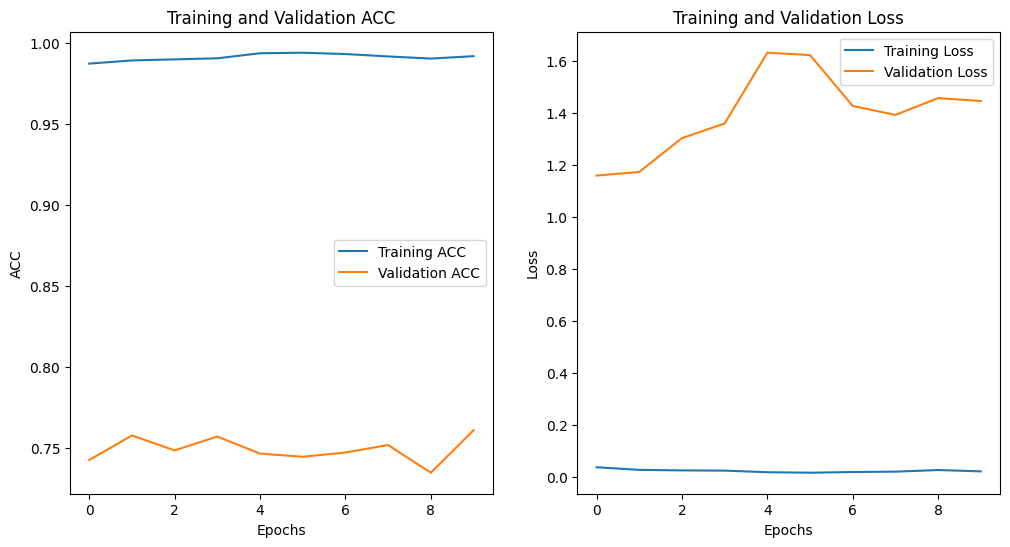

In [127]:
plot_acc_and_loss(history)

In [151]:
submission_csv = 'data/test.csv'

submission_df = pd.read_csv(submission_csv)

x_submission = tokenizer.texts_to_sequences(test_df['text'])

x_submission_pad = pad_sequences(x_submission, maxlen=max_len, padding="post", truncating="post")

def generate_test_prediction(m, file_name):
    y_pred_prob = m.predict(x_submission_pad)
    
    y_pred = (y_pred_prob > 0.5).astype(int).flatten() 
        
    df_results = pd.DataFrame({
        "id": [i for i in submission_df['id']],
        "target": y_pred
    })
    
    df_results.to_csv(f"{file_name}.csv", index=False)
    print(f"{file_name}.csv saved")

In [152]:
generate_test_prediction(model, 'model_v1')

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
model_v1.csv saved


### Results and Analysis

In this section we are going to make a hyperparameter tuning. Now, we are going to extend the model architecture using Bidirectional LSTM and applying Dropout to avoid the overfitting.

In [162]:
embedding_dim = 100
lstm_units = 64 
dropout_rate = 0.3
learning_rate = 0.001

model_2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    LSTM(lstm_units),
    Dropout(dropout_rate),
    Dense(1, activation="sigmoid")
])

model_2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

model_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [164]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    X_train_pad, 
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - acc: 0.9266 - loss: 0.1998 - val_acc: 0.7787 - val_loss: 0.5056
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - acc: 0.9564 - loss: 0.1347 - val_acc: 0.7781 - val_loss: 0.6564
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - acc: 0.9754 - loss: 0.0790 - val_acc: 0.7781 - val_loss: 0.6090
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - acc: 0.9775 - loss: 0.0692 - val_acc: 0.7669 - val_loss: 0.7390


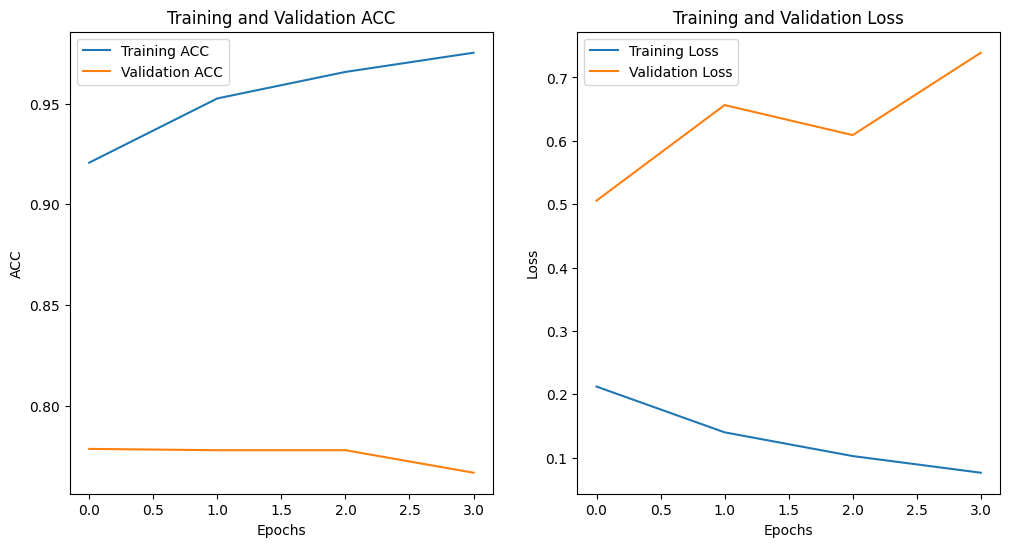

In [165]:
plot_acc_and_loss(history_2)

In [200]:
generate_test_prediction(model_2, 'model_v2')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
model_v2.csv saved


Now, We are going to tune the hyper-parameters of the model using the next values:

- Embendding dimenssion: [100, 150, 200]
- LSTM units: [64, 128, 256]
- Dropout: 0.4 to 0.7
- learning rate: [0.001, 0.005, 0.0001]


In [201]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=hp.Choice("embedding_dim", [100, 150, 200]), input_length=max_len),
        Bidirectional(LSTM(hp.Choice("lstm_units", [64, 128, 256]), return_sequences=True)),
        Dropout(hp.Float("dropout", min_value=0.4, max_value=0.7, step=0.1)),
        LSTM(hp.Choice("lstm_units", [64, 128, 256])),
        Dropout(hp.Float("dropout", min_value=0.4, max_value=0.7, step=0.1)),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")]
    )
    
    return model

In [218]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_acc",
    max_trials=25
)

tuner.search(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10)


Trial 25 Complete [00h 00m 45s]
val_acc: 0.784635603427887

Best val_acc So Far: 0.8115561604499817
Total elapsed time: 01h 04m 58s


In [219]:
best_model = tuner.get_best_models(num_models=1)[0]

In [220]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")

embedding_dim: 200
lstm_units: 128
dropout: 0.6000000000000001
learning_rate: 0.001


In [221]:
generate_test_prediction(best_model, 'model_v3')

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
model_v3.csv saved


The best model gets an accuracy of 96% and validation accuracy of 77%. It was done with the next hyperparameters:

- embedding_dim: 200
- lstm_units: 128
- Dropout: 0.6
- learning_rate: 0.001

### Conclusion

- The first model is composed of 1 embedding layer, 2 LSTMs, and 1 dense layer. This model gets 76% accuracy in the validation set. This model shows an overfitting signal by the difference in the accuracy between the training and test sets. Because the model architecture is basic and the hyperparameters are not tuned.
- The second model is composed of 1 embedding layer, 2 LSTMs, 2 Dropout layers, and 1 dense layer. The Dropout layers are included in order to avoid the overfiting. However, the was not a big redution in the training accuracy of the model with 97%. However, the validation accuracy is still in 76% .
- The hyper-parameter tunning process give us the values of embedding_dim, lstm_units, Dropout and, learning_rate that maximixe the validation test accuracy. the best model get a validation accuracy of 81%.
- Another improvement that you can apply in the project is tuning the hyper-parameter of the tokenizer process. the word number and the max sentence length.
- For future optimization, we can try using GRU or CNN-LSTM layers.